In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [42]:
# Run model prep notebook
%run Model_prep.ipynb

In [105]:
# Read in dataset
# train_df = pd.read_csv('train.csv')
train_df = pd.read_csv('train_sample.csv')
train_df.head()

,gameId,playId,nflId,frameId,x,y,unitDir,unitO,force,home,...,offenseFormation,absoluteYardlineNumber,timeSinceStart,preSnapHomeScore,preSnapVisitorScore,surface,inside_outside,weight,position,gamePlayId
0,2.022091e+09,56.0,38577.0,6.0,41.89,24.593333,272.29,280.53,288.200000,1,...,SHOTGUN,85,0,0,0,turf,inside,242,ILB,2022090800.056.0
1,2.022091e+09,56.0,41239.0,6.0,27.85,23.373333,112.35,83.84,364.000000,1,...,SHOTGUN,85,0,0,0,turf,inside,280,DT,2022090800.056.0
2,2.022091e+09,56.0,42816.0,6.0,49.38,45.673333,351.67,298.43,346.254545,1,...,SHOTGUN,85,0,0,0,turf,inside,184,CB,2022090800.056.0
3,2.022091e+09,56.0,43294.0,6.0,41.85,15.483333,91.50,129.04,116.290909,1,...,SHOTGUN,85,0,0,0,turf,inside,208,CB,2022090800.056.0
4,2.022091e+09,56.0,43298.0,6.0,27.89,20.193333,66.47,110.88,241.090909,1,...,SHOTGUN,85,0,0,0,turf,inside,240,DE,2022090800.056.0


In [106]:
train_df.isna().sum()

train_df['tackle_efficiency_ingame'].fillna(0, inplace=True)
train_df['tackle_rating_ingame'].fillna(0, inplace=True)

train_df.isna().sum()

gameId            0
playId            0
nflId             0
frameId           0
x                 0
                 ..
surface           0
inside_outside    0
weight            0
position          0
gamePlayId        0
Length: 83, dtype: int64

In [4]:
extend_dv = 'tackle_binary_single'

# Identify rows where tackle_binary_single is equal to 1
tackle_rows = train_df[train_df['tackle_binary_single'] == 1]

# Create a list to store the indices of rows to be updated
rows_to_update = []

# Get identifiers for each row with tackle_binary_single = 1 
for _, row in tackle_rows.iterrows():
    gamePlayId = row['gamePlayId']
    nflId = row['nflId']
    frameId = row['frameId']

    # Identify the rows to be updated based on gamePlayId, nflId, and frame
    rows_to_update.extend(
        train_df[
            (train_df['gamePlayId'] == gamePlayId) &
            (train_df['nflId'] == nflId) &
            ((train_df['frameId'] >= frameId - 2) & (train_df['frameId'] <= frameId + 2))
        ].index
    )

# Update the values in the identified rows
train_df.loc[rows_to_update, 'tackle_binary_single'] = 1

In [108]:
# Get x, y, mask, and id mapping variables from data tensor function
target_variable = 'tackle_binary_single'
x, y, mask, id_data = data_tensors_rnn_3d(train_df, target_variable, True)

In [109]:
# Print shapes of variables
print(x.shape)
print(y.shape)
print(mask.shape)
print(id_data.shape)

torch.Size([14399, 140, 91])
torch.Size([14399, 140])
torch.Size([14399, 140])
(2015860, 3)


In [110]:
split_ratio = 0.8
num_players = 11
num_frames = 140
num_plays = x.shape[0] / num_players
print(num_plays)
plays_to_split = int(num_plays * split_ratio)
print(plays_to_split)
to_split = plays_to_split * num_players
print(to_split)

x_train = x[:to_split]
y_train = y[:to_split]
mask_train = mask[:to_split]
id_train = id_data[:to_split * num_frames]

x_test = x[to_split:]
y_test = y[to_split:]
mask_test = mask[to_split:]
id_test = id_data[to_split:]

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("mask_train shape: ", mask_train.shape)
print("id_train shape: ", x_train.shape)

print("\nx_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)
print("mask_test shape: ", mask_test.shape)
print("id_test shape: ", x_test.shape)

1309.0
1047
11517
x_train shape:  torch.Size([11517, 140, 91])
y_train shape:  torch.Size([11517, 140])
mask_train shape:  torch.Size([11517, 140])
id_train shape:  torch.Size([11517, 140, 91])

x_test shape:  torch.Size([2882, 140, 91])
y_test shape:  torch.Size([2882, 140])
mask_test shape:  torch.Size([2882, 140])
id_test shape:  torch.Size([2882, 140, 91])


In [111]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)  # Additional fully connected layer
        self.relu = nn.ReLU()  # Activation function (you can choose a different one)
        self.fc2 = nn.Linear(64, output_size)  # Output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # RNN layer
        out, _ = self.rnn(x)

        # Fully connected layer 1
        out = self.fc1(out)
        out = self.relu(out)

        # Fully connected layer 2 (output layer)
        out = self.fc2(out)

        # Apply sigmoid activation for binary classification
        out = self.sigmoid(out)

        return out


In [112]:
# Assuming x_train is your PyTorch tensor
x_train_shape = x_train.size() 

# Extracting each dimension into separate variables
num_samples, num_timesteps, num_features = x_train_shape

# Printing the values of each dimension
print("Number of samples:", num_samples)
print("Number of timesteps:", num_timesteps)
print("Number of features:", num_features)

# Assuming you have your input data ready (x_train) and labels (y_train)
hidden_size = 32
output_size = 1  # Output size for each timestep

Number of samples: 11517
Number of timesteps: 140
Number of features: 91


In [113]:
import torch
import torch.nn as nn
import torch.optim as optim

# Instantiate the model
model = RNNModel(num_features, hidden_size, output_size)

# Define the Binary Cross Entropy (BCE) with logits loss and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate as needed

# Training loop (example, adjust based on your actual training process)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass with sigmoid activation
    outputs = model(x_train)
    outputs = outputs.view(-1, num_timesteps)  # Reshape to match y_train dimensions
    loss = criterion(outputs, y_train.float())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # After each epoch, evaluate and print training loss and accuracy
    model.eval()
    with torch.no_grad():
        train_predictions = model(x_train)
        train_predictions = train_predictions.view(-1, num_timesteps)
        
        # Calculate training accuracy
        predicted_labels = (train_predictions > 0.5).float()
        correct_predictions = (predicted_labels == y_train.float())
        accuracy = correct_predictions.sum().item() / correct_predictions.numel()

        print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {loss.item()}, Training Accuracy: {accuracy}")

# After training, you can use the model to make predictions and evaluate log loss on the test set
model.eval()
with torch.no_grad():
    test_predictions = model(x_test)
    test_predictions = test_predictions.view(-1, num_timesteps)  # Reshape predictions

# Evaluate log loss on the test set
test_loss = criterion(test_predictions, y_test.float())

# Print or use the predictions and loss as needed
print("Test Predictions:", test_predictions)
print("Test Loss:", test_loss.item())


Epoch 1/10 - Training Loss: 0.9603979587554932, Training Accuracy: 0.9644190575422668
Epoch 2/10 - Training Loss: 0.9563014507293701, Training Accuracy: 0.9772708666691474
Epoch 3/10 - Training Loss: 0.9522808194160461, Training Accuracy: 0.9860913680397921
Epoch 4/10 - Training Loss: 0.9483038187026978, Training Accuracy: 0.9914697527878044
Epoch 5/10 - Training Loss: 0.9444955587387085, Training Accuracy: 0.9946737121522222
Epoch 6/10 - Training Loss: 0.940859317779541, Training Accuracy: 0.9965101278854861
Epoch 7/10 - Training Loss: 0.937356173992157, Training Accuracy: 0.9975892779617708
Epoch 8/10 - Training Loss: 0.9339007139205933, Training Accuracy: 0.9982380084099282
Epoch 9/10 - Training Loss: 0.9304249882698059, Training Accuracy: 0.9986070281199221
Epoch 10/10 - Training Loss: 0.9268833994865417, Training Accuracy: 0.9988563489996155
Test Predictions: tensor([[0.4461, 0.4265, 0.4120,  ..., 0.4216, 0.4216, 0.4216],
        [0.3936, 0.3942, 0.3992,  ..., 0.4216, 0.4216, 0.42

(array([3.32000e+02, 1.59900e+03, 5.70100e+03, 1.14370e+04, 1.76020e+04,
        3.41644e+05, 1.56960e+04, 7.14300e+03, 2.12600e+03, 2.00000e+02]),
 array([0.23191483, 0.26164666, 0.29137847, 0.32111028, 0.35084209,
        0.3805739 , 0.41030571, 0.44003755, 0.46976936, 0.49950117,
        0.52923298]),
 <BarContainer object of 10 artists>)

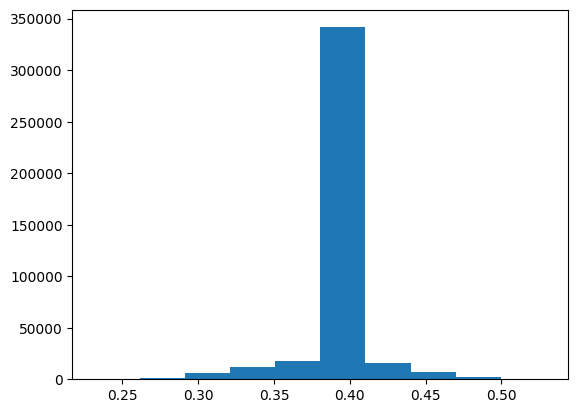

In [117]:
import matplotlib.pyplot as plt
x = pd.DataFrame(test_predictions.flatten())
x

plt.hist(x)

In [116]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)  # Additional fully connected layer
        self.relu = nn.ReLU()  # Activation function (you can choose a different one)
        self.fc2 = nn.Linear(64, output_size)  # Output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # RNN layer
        out, _ = self.rnn(x)

        # Fully connected layer 1
        out = self.fc1(out)
        out = self.relu(out)

        # Fully connected layer 2 (output layer)
        out = self.fc2(out)

        # Apply sigmoid activation for binary classification
        out = self.sigmoid(out)

        return out

# Assuming x_train is your PyTorch tensor
x_train_shape = x_train.size() 

# Extracting each dimension into separate variables
num_samples, num_timesteps, num_features = x_train_shape

# Printing the values of each dimension
print("Number of samples:", num_samples)
print("Number of timesteps:", num_timesteps)
print("Number of features:", num_features)

# Assuming you have your input data ready (x_train) and labels (y_train)
hidden_size = 32
output_size = 1  # Output size for each timestep

import torch
import torch.nn as nn
import torch.optim as optim

# Instantiate the model
model = RNNModel(num_features, hidden_size, output_size)

# Define the Binary Cross Entropy (BCE) with logits loss and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate as needed

# Training loop (example, adjust based on your actual training process)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass with sigmoid activation
    outputs = model(x_train)
    outputs = outputs.view(-1, num_timesteps)  # Reshape to match y_train dimensions
    loss = criterion(outputs, y_train.float())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # After each epoch, evaluate and print training loss and accuracy
    model.eval()
    with torch.no_grad():
        train_predictions = model(x_train)
        train_predictions = train_predictions.view(-1, num_timesteps)
        
        # Calculate training accuracy
        predicted_labels = (train_predictions > 0.5).float()
        correct_predictions = (predicted_labels == y_train.float())
        accuracy = correct_predictions.sum().item() / correct_predictions.numel()

        print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {loss.item()}, Training Accuracy: {accuracy}")

# After training, you can use the model to make predictions and evaluate log loss on the test set
model.eval()
with torch.no_grad():
    test_predictions = model(x_test)
    test_predictions = test_predictions.view(-1, num_timesteps)  # Reshape predictions

# Evaluate log loss on the test set
test_loss = criterion(test_predictions, y_test.float())

# Print or use the predictions and loss as needed
print("Test Predictions:", test_predictions)
print("Test Loss:", test_loss.item())


Number of samples: 11517
Number of timesteps: 140
Number of features: 91
Epoch 1/10 - Training Loss: 0.9624685049057007, Training Accuracy: 0.9819819149332043
Epoch 2/10 - Training Loss: 0.9580424427986145, Training Accuracy: 0.9878614222453764
Epoch 3/10 - Training Loss: 0.9532633423805237, Training Accuracy: 0.9916322455004404
Epoch 4/10 - Training Loss: 0.948207676410675, Training Accuracy: 0.994111189669929
Epoch 5/10 - Training Loss: 0.9425910115242004, Training Accuracy: 0.9956877411032139
Epoch 6/10 - Training Loss: 0.9367266893386841, Training Accuracy: 0.9967569679604064
Epoch 7/10 - Training Loss: 0.9308890700340271, Training Accuracy: 0.9975297386472172
Epoch 8/10 - Training Loss: 0.9248045086860657, Training Accuracy: 0.9980203177910915
Epoch 9/10 - Training Loss: 0.9182944893836975, Training Accuracy: 0.9983366203996576
Epoch 10/10 - Training Loss: 0.9112234711647034, Training Accuracy: 0.9985319837755368
Test Predictions: tensor([[0.4237, 0.4219, 0.4218,  ..., 0.3850, 0.3